<a href="https://colab.research.google.com/github/langfordzd/bursts-cc-pt/blob/main/burst_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Frequency-specific patterns of neural activity, as observed in magneto/electroencephalography (M/EEG) and local field potentials (LFPs) in humans and animals, have traditionally been thought of as temporally sustained oscillations in the excitability of the underlying neural tissue. Traditional methods of analyses are however based on trial averaging which can possible obscure the termporal characteristis of the oscillatory activity. Specifically, it appears that this activity in certain frequencies is not sustained at all, rather the act of averaging is making transient 'burst' events appear to be sustained. 

And while this appears to be true, detecting and describing bursts is a challenging endevour because it involves single trial analysis. There are a few ways that researchers have considered detecting such transient events in neural recordings that we know of; placing a power-threshold (**PT**) on a time-frequnecy map, using hidden Markov models on the amplitude envelope of the signal, and looking at the raw, or lightly altered, signal in an attempt to quantify consistent oscillatory cycles. 

In this work we will focus on both the most prominent method, the **PT** method, used to detect beta bursts in a neural signal; and in developing the cycle-consistency (**CC**) method which is based of the cycle-by-cycle technique of analysis. First we simulate realistic neural data with beta bursts that have different distributions of burst characteristics and evaluate how each method classifies bursts under each.  Following this we use each method to detail the characteristics of the bursts recovered in pre-existing mouse and macaque local field potentials, and macaque ECoG; detailing the differences of burst characteristics between each method. 


# Let's load data and scripts for the monkey LFP, mouse LFP, monkey ECoG, and simulation results
We will grab the data from osf.io and the python files we need from github. The dataframes with the names of mouse, lfp (marco,pablo), and ecog are the results of both the CC and PTA method. The ones appended _trials are the actual data, appended _bs is behavior of the trial structures, and _ids is the total number of trials. We don't look at the mouse behavior so it is missing. Then there is the sim file which contains a lot of different files to help us plot the simulation. We then import the .py files we grabbed from github. These are all helpers for each of the panel plots, and for calculating statistics. 

In [1]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [2]:
!git clone https://github.com/langfordzd/bursts-cc-pt.git

Cloning into 'bursts-cc-pt'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 109 (delta 56), reused 92 (delta 48), pack-reused 3
Receiving objects: 100% (109/109), 1.14 MiB | 3.52 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
import sys
sys.path.insert(0,'/content/bursts-cc-pt')

In [ ]:
!curl -L -J -O 'https://osf.io/r84ma/download'
!unzip results.zip

In [4]:
#you will not want to run this if you ran the curl and unzip command directly above and are not on my pc
!unzip '/content/drive/MyDrive/bursts_notebook/results.zip' -d '/content/'

Archive:  /content/drive/MyDrive/bursts_notebook/results.zip
  inflating: /content/ecog_com.json  
  inflating: /content/ecog_objs.pkl  
  inflating: /content/lfp_com.json   
  inflating: /content/lfp_objs.pkl   
  inflating: /content/mouse_com.json  
  inflating: /content/mouse_objs.pkl  
  inflating: /content/sim.pkl        


In [5]:
import pandas as pd
import json
with open("mouse_com.json", "r") as fp:  
    mouse = pd.read_json(json.load(fp)) 
    mouse['which'] = mouse['which'].replace(['pt_com','pt'],['co','pta'])
    mouse0 = mouse[mouse['loc']==0]
    mouse1 = mouse[mouse['loc']==1]  
with open("lfp_com.json", "rb") as fp:   
    lfp = pd.read_json(json.load(fp))
    lfp['which'] = lfp['which'].replace(['pt_com','pt'],['co','pta'])
    lfp['loc'] = lfp['loc']+lfp['chan'].astype(str)
    lfp['monkey'] = lfp['loc'].astype(str).str[0]
    marco = lfp[lfp['monkey']=='M']
    pablo = lfp[lfp['monkey']=='P']
with open("ecog_com.json", "rb") as fp:   
    ecog = pd.read_json(json.load(fp)) 
    ecog['which'] = ecog['which'].replace(['pt_com','pt'],['co','pta'])

In [6]:
import pickle
with open("ecog_objs.pkl", "rb") as fp:  
    ecog_trials, ecog_bs, ecog_ids, _, _, _ = pickle.load(fp)
with open("lfp_objs.pkl", "rb") as fp:  
    lfp_trials, lfp_bs, lfp_ids, _, _ = pickle.load(fp)
with open("sim.pkl", "rb") as fp:  
    mf_pf,mh_ph,xax,zeros,ones,twos,m_f,m_p,n_levels = pickle.load(fp)

In [7]:
import matplotlib as mpl
import plot1, plot2, plot3, sims

#First we look at how each method recovers bursts in a simulation

We started our examination of bursts by simulating realistic burst data to get an understanding of burst detection methods in a situation where we know the ground-truth. We created twenty-five different simulated data sets for three different levels of burst probability, and a coloured-noise simulation. We then applied each method to the simulated data sets and categorized each burst as being well-recovered or not.  The distributions for both the burst amplitude and frequency can be seen in **Panel D**. The chance that any given trial in a simulation would contain a certain amount of bursts over the different burst probability levels can bee seen in **Panel C**. Finally, the averaged PSD for each set of the burst probability levels can be seen in **Panel E**.

If a recovered burst shared at least half of its time-points with a ground-truth burst, but was not more than twice as long, it was considered well-recovered. In **Panel B** we can see quite well that the CC method recovers the bursts at a high an consistent rate, while the PT method recovers at its highest about 75%. If a burst was produced by a method and it was not well-recovered it was considered a false-burst. Evaluating the method using these metrics we found that while the CC method did not produce false bursts, the PT method produced at fairly high rates at both the low and high end of burst probability spectrum, which can be seen in **Panel A**.

Given the performance on producing false bursts of the PT method we modified it to only recover a burst if the burst was over 2 cycles long at its specific frequency, this is plotted as **PTA** in both **Panel A and B** and is the method we preferred in examining the electrophysiological data.

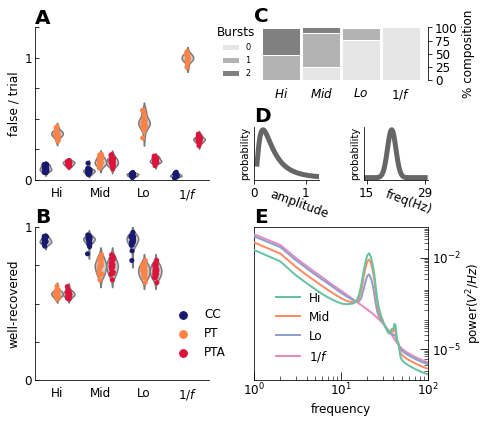

In [ ]:
sims.sim_plot(mf_pf,mh_ph,xax,zeros,ones,twos,m_f,m_p,n_levels)

# How did we pick the parameters for the CC method?

We tried to chose sets of parameters that didn't give us bursts in 1/f noise as shown here: https://github.com/langfordzd/bursts-cc-pt/blob/main/parameter_picks.ipynb



# Burst Characteristics

In this plot we see duration scattered against amplitude in the 3 leftmost plots for the PTA, CC, and CO(mmon) bursts found in the mouse (**A**), LFP (**B**), and ECoG (**C**) datasets. The rightmost plots show the frequency of the detected bursts for each method and dataset.

Both the frequency and the amplitude were calculated independently on the raw (or epoched) signal using the instantaneous methods provided by [NeuroDSP](https://neurodsp-tools.github.io/). We wanted to be able to compare them on equal footing. Of course, one of the interesting things with the CC method is the ability to describe individual cycles, which is something we do not touch on here, but can be seen in the [Bycycle](https://github.com/bycycle-tools/bycycle) package. 

**Note:** We should keep in mind that for a burst to be in the common plot it has to have 50% overlap between PTA and CC bursts, and not more than twice as long. If the relax these constraints we get the same picture in any case.

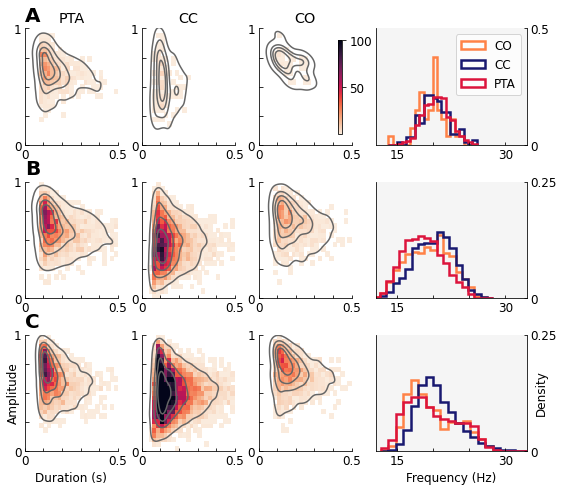

In [ ]:
plot1.amp_dur(mouse,lfp,ecog)


#Duration, amplitude, frequency, and count differences abound
What we see below are paired sampled permutation tests done on the unique bursts (i.e., the CC and PTA plots above) averaged per unit (e.g., ECoG session, or LFP channel). We have first listed the overall mean, then the number of permuted t-values more extreme than the observed, and then Cohen's d as a measure of effect size.  


**Duration**

For all but the ECoG data the duration of the CC method was shorter than the PTA method. We should keep in mind though that each method could give different time-points for the same burst (e.g., CC method will start and stop on a cycle trough, but PTA doesn't have this constratint).

In [ ]:
plot1.stats(mouse0,'duration', 'mouse')
plot1.stats(mouse1,'duration', 'mouse')
plot1.stats(marco,'duration', 'marco')
plot1.stats(pablo,'duration', 'pablo')
plot1.stats(ecog,'duration', 'ecog')


-------------------------------------------
Analysis of mouse duration
CC: 0.113 ( 0.00886 ) PTA 0.157 ( 0.0083 )
0 of 10000 more extreme than observed p=  0.0
Cohen's d=  -4.616707354401246
-------------------------------------------

-------------------------------------------
Analysis of mouse duration
CC: 0.116 ( 0.0087 ) PTA 0.151 ( 0.00335 )
0 of 10000 more extreme than observed p=  0.0
Cohen's d=  -4.782665354808992
-------------------------------------------

-------------------------------------------
Analysis of marco duration
CC: 0.131 ( 0.00882 ) PTA 0.169 ( 0.0133 )
0 of 10000 more extreme than observed p=  0.0
Cohen's d=  -3.269116365172908
-------------------------------------------

-------------------------------------------
Analysis of pablo duration
CC: 0.144 ( 0.0108 ) PTA 0.166 ( 0.0396 )
25 of 10000 more extreme than observed p=  0.0025
Cohen's d=  -0.7338889989116726
-------------------------------------------

-------------------------------------------
Analysis

**Amplitude**

For each dataset we analyzed we see that the CC method gives us lower amplitude bursts, at the level of the mean.

In [ ]:
plot1.stats(mouse0,'amp', 'mouse')
plot1.stats(mouse1,'amp', 'mouse')
plot1.stats(marco,'amp', 'marco')
plot1.stats(pablo,'amp', 'pablo')
plot1.stats(ecog,'amp', 'ecog')

-------------------------------------------
Analysis of mouse amp
CC: 0.531 ( 0.0646 ) PTA 0.629 ( 0.0141 )
0 of 10000 more extreme than observed p=  0.0
Cohen's d=  -1.873897782637132
-------------------------------------------

-------------------------------------------
Analysis of mouse amp
CC: 0.551 ( 0.0613 ) PTA 0.647 ( 0.00704 )
0 of 10000 more extreme than observed p=  0.0
Cohen's d=  -1.9610447358544405
-------------------------------------------

-------------------------------------------
Analysis of marco amp
CC: 0.449 ( 0.0197 ) PTA 0.612 ( 0.0283 )
0 of 10000 more extreme than observed p=  0.0
Cohen's d=  -6.415505598619273
-------------------------------------------

-------------------------------------------
Analysis of pablo amp
CC: 0.491 ( 0.0292 ) PTA 0.629 ( 0.0484 )
2 of 10000 more extreme than observed p=  0.0002
Cohen's d=  -3.3651780942751843
-------------------------------------------

-------------------------------------------
Analysis of ecog amp
CC: 0.511

**Frequency**

Interestingly the frequency in the PTA method is lower, in both the LFP and ECoG data.

In [ ]:
plot1.stats(mouse0,'freq', 'mouse')
plot1.stats(mouse1,'freq', 'mouse')
plot1.stats(marco,'freq', 'marco')
plot1.stats(pablo,'freq', 'pablo')
plot1.stats(ecog,'freq', 'ecog')

-------------------------------------------
Analysis of mouse freq
CC: 20.4 ( 0.18 ) PTA 20.6 ( 0.102 )
1306 of 10000 more extreme than observed p=  0.1306
Cohen's d=  -1.086221597654776
-------------------------------------------

-------------------------------------------
Analysis of mouse freq
CC: 20.1 ( 0.52 ) PTA 20.2 ( 0.275 )
5627 of 10000 more extreme than observed p=  0.5627
Cohen's d=  -0.21911423388323073
-------------------------------------------

-------------------------------------------
Analysis of marco freq
CC: 18.8 ( 0.493 ) PTA 17.8 ( 0.577 )
0 of 10000 more extreme than observed p=  0.0
Cohen's d=  1.79314465564843
-------------------------------------------

-------------------------------------------
Analysis of pablo freq
CC: 20.7 ( 1.23 ) PTA 20.0 ( 1.04 )
14 of 10000 more extreme than observed p=  0.0014
Cohen's d=  0.5933638302485461
-------------------------------------------

-------------------------------------------
Analysis of ecog freq
CC: 20.5 ( 0.1

**Count**

Possibly the most striking difference is in the count of bursts with the CC method giving 2-4 times the amount of bursts (with the exception of the mouse data, in which the CC method didn't find many bursts).

In [ ]:
plot1.stats(mouse0,'count', 'mouse0')
plot1.stats(mouse1,'count', 'mouse1')
plot1.stats(marco,'count', 'marco')
plot1.stats(pablo,'count', 'pablo')
plot1.stats(ecog,'count', 'ecog')

-------------------------------------------
Analysis of mouse0 count
pta    411
cc      72
co      19
Name: which, dtype: int64
-------------------------------------------

-------------------------------------------
Analysis of mouse1 count
pta    363
cc      64
co      24
Name: which, dtype: int64
-------------------------------------------

-------------------------------------------
Analysis of marco count
cc     2393
pta    1669
co      502
Name: which, dtype: int64
-------------------------------------------

-------------------------------------------
Analysis of pablo count
cc     2777
pta    1065
co      556
Name: which, dtype: int64
-------------------------------------------

-------------------------------------------
Analysis of ecog count
cc     11344
pta     2989
co      1894
Name: which, dtype: int64
-------------------------------------------



# What is the difference in the waveforms?

Next we took all of the bursts and for each one found the most extreme points. We then aligned all the bursts at these points. Given the constraints on the amount of data in the mouse (**A**) and LFP (**B**) we simply averaged over all bursts, ignoring session or recording location. The ECoG (**C**) data was different however in that we had 400 trials * 25 session, so we first averaged over the trials per session and then plotted the averaged waveform. The gray dashed vertical lines mark the time of 1 cycle.

What we see is that for the mouse there is not really enough CC bursts to make a judgment, but the PTA method definitely doesn't show much apparent rhythmicity. In the LFP we see that the gray lines meet a peak multiple times in the CC method, and only a few times in the PTA. In the ECoG data we see many clear meeting between the averaged data peaks and the cycle markers, and in the PTA method there are again only a few.

**Note:** You can also align by the minimum phase and plot it if you set 'phase = True'.

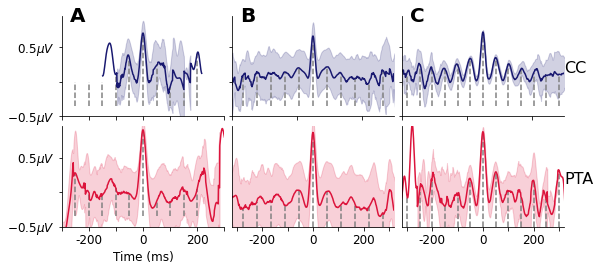

In [ ]:
mouse_frx = [19,21]
lfp_frx = [16,20]
ecog_frx  = [19,21]
phase = False
mouse_f = mouse.loc[(mouse['freq'] >= mouse_frx[0]) & (mouse['freq'] <= mouse_frx[1])]
cc_mouse, pt_mouse = plot2.find_burst_data(mouse_f,phase)
lfp_f = lfp.loc[(lfp['freq'] >= lfp_frx[0]) & (lfp['freq'] <= lfp_frx[1])]
cc_lfp, pt_lfp = plot2.find_burst_data(lfp_f,phase)
ecog_f = ecog.loc[(ecog['freq'] >= ecog_frx[0]) & (ecog['freq'] <= ecog_frx[1])]
cc_ecog, pt_ecog = plot2.find_burst_data_mean_session(ecog_f,phase)

ylims = [-0.35,0.95]
dash = 'gray'
plot2.brp(
        cc_mouse,pt_mouse,mouse_frx,
        cc_lfp,pt_lfp,lfp_frx,
        cc_ecog,pt_ecog,ecog_frx,
        ylims, dash)

# What can we say about behavior?

Given that the bursts we find seem to be found in unique locations we wondered if they might be distributed differently across the trial structure. Below in **A** we first calculated for each trial the number of bursts for each method, we then split this calculation by **S**earch and **R**epetition trials in the leftmost panel. In the middle we calculated for each recording location the ratio of Search to Repetition we observed in the behavioral data and plotted this against the same ratio but calculated with the bursts. If the burst data was in an equal proportion as seen in the behavioral it would lie on the straight line.  We went ahead and tested this with a 1-sided paired permutation test and found that the CC burst ratio was greater than what was found in the behavioral data, and the PT method burst ratio was less. This means that CC bursts are more likely to be found in the search epoch, and PT burst more likely in the repetition epoch. In **B** we find the same exact pattern in the ECoG data. 

**C** are violinplots of the duration, amplitude, and frequency split by both the method, and the Search or Repetition behavior for monkey Pablo, Marco, and the ECoG data. While it is quite clear, just like as before, that the different methods find very different bursts, the picture of how these characteristics play out with behavior is not nearly as clear. 

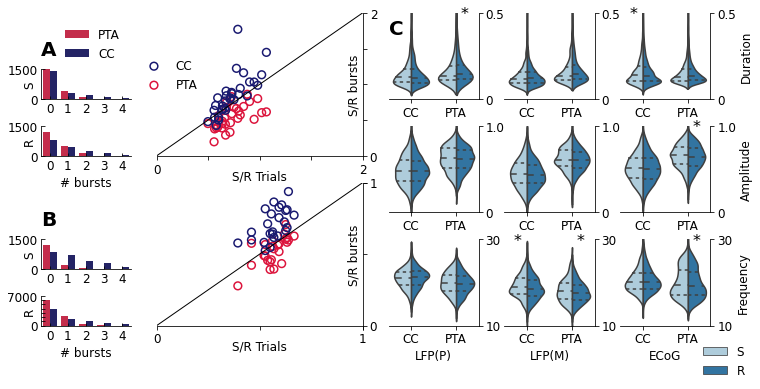

In [ ]:
pt_lfp_b, pt_lfp_c      = plot3.behav(lfp,lfp_bs,lfp_trials,'pta', lfp_ids)
cc_lfp_b, cc_lfp_c      = plot3.behav(lfp,lfp_bs,lfp_trials,'cc', lfp_ids)
pt_ecog_b, pt_ecog_c    = plot3.behav(ecog,ecog_bs,ecog_trials,'pta',ecog_ids)
cc_ecog_b, cc_ecog_c    = plot3.behav(ecog,ecog_bs,ecog_trials,'cc',ecog_ids)

vio_col = 'Paired'
plot3.plot_beh(pt_lfp_b,pt_lfp_c,cc_lfp_b,cc_lfp_c,pt_ecog_b,pt_ecog_c,cc_ecog_b,cc_ecog_c,ecog,marco,pablo,vio_col,False)

In [ ]:
count_lfp = pd.concat([pt_lfp_c,cc_lfp_c])
count_ecog = pd.concat([pt_ecog_c,cc_ecog_c])
behav_lfp = pd.concat([pt_lfp_b,cc_lfp_b])
behav_lfp['monkey'] = behav_lfp['loc'].astype(str).str[0]
behav_ecog = pd.concat([pt_ecog_b,cc_ecog_b])
behav_marco = behav_lfp[(behav_lfp.monkey=='M')]
behav_pablo = behav_lfp[(behav_lfp.monkey=='P')]

This next block of code will take the ratios of search to repetition trials that were seen in the trial structure for each unit (LFP electrode or ECoG session) and test it against the ratio of bursts seen in the search to repetition trials. We test it in two ways, one is a paired samples permutation test, which is what we saw earlier as well. The other way to think of it is to do a [binomial test](https://en.wikipedia.org/wiki/Binomial_test). If the burst ratio is not different than the trial ratio one would expect half the burst ratios to be under the line and half over, a binomial test  with p=0.5 will test just this. In both cases we would consider the CC burst ratios to be higher (though Marco CC is not significant at p=0.05 in the binomial test) and the PT burst ratios to be lower. In this sense you find relatively more CC bursts in the search period than the repetition period, and the opposite for the PT bursts.

In [ ]:
plot3.perm_binom_test(behav_marco,'marco','pta')
plot3.perm_binom_test(behav_marco,'marco','cc')
plot3.perm_binom_test(behav_pablo,'pablo','pta')
plot3.perm_binom_test(behav_pablo,'pablo','cc')
plot3.perm_binom_test(behav_ecog,'ecog','pta')
plot3.perm_binom_test(behav_ecog,'ecog','cc')

-------------------------------------------
Analysis of marco pta
Permutation:
0 of 10000 more extreme than observed p=  0.0
Binomial:
14 out of 15 less than trial ratio
p=  0.0004882812499999999
-------------------------------------------

-------------------------------------------
Analysis of marco cc
Permutation:
39 of 10000 more extreme than observed p=  0.0039
Binomial:
11 out of 15 greater than trial ratio
p=  0.059234619140624986
-------------------------------------------

-------------------------------------------
Analysis of pablo pta
Permutation:
1 of 10000 more extreme than observed p=  0.0001
Binomial:
15 out of 17 less than trial ratio
p=  0.0011749267578125
-------------------------------------------

-------------------------------------------
Analysis of pablo cc
Permutation:
49 of 10000 more extreme than observed p=  0.0049
Binomial:
14 out of 17 greater than trial ratio
p=  0.006362915039062502
-------------------------------------------

--------------------------

**Duration** 
Below we see the tests for duration as split by either Search or Repeat, on the top for PT and the bottom for CC. The tests are two-sided paired samples permutation tests. For the PT method they all are in the same direction, with seach bursts being faster than repetition, but only one is significant at p=0.05, and the [effects sizes](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) of all of them are small to medium. For the CC method the search period durations are longer only for the ECoG data and the effect is a medium sized effect.

In [ ]:
print('**************PT Duration**************')
plot3.perm_freq_amp_dur(marco,'marco','pta','duration')
plot3.perm_freq_amp_dur(pablo,'pablo','pta','duration')
plot3.perm_freq_amp_dur(ecog,'ecog','pta','duration')
print('**************CC Duration**************')
plot3.perm_freq_amp_dur(marco,'marco','cc','duration')
plot3.perm_freq_amp_dur(pablo,'pablo','cc','duration')
plot3.perm_freq_amp_dur(ecog,'ecog','cc','duration')


**************PT Duration**************
--------------------------------------------
Analysis of marco duration for pta
search: 0.162 ( 0.0138 ) repeat 0.171 ( 0.0167 )
958 of 10000 more extreme than observed p=  0.0958
Cohen's d=  -0.5746475861144967
--------------------------------------------

--------------------------------------------
Analysis of pablo duration for pta
search: 0.158 ( 0.0381 ) repeat 0.17 ( 0.0416 )
256 of 10000 more extreme than observed p=  0.0256
Cohen's d=  -0.2849296452696725
--------------------------------------------

--------------------------------------------
Analysis of ecog duration for pta
search: 0.151 ( 0.011 ) repeat 0.153 ( 0.0104 )
4106 of 10000 more extreme than observed p=  0.4106
Cohen's d=  -0.203255761908697
--------------------------------------------

**************CC Duration**************
--------------------------------------------
Analysis of marco duration for cc
search: 0.132 ( 0.00938 ) repeat 0.13 ( 0.0101 )
5967 of 10000 more ex

**Amplitude** In the following cell we see that in the PT method the seach period has, taken all together, consistently higher amplitude bursts than the repetition period. The effect size are small to medium, again. For the CC method, we found no evidence of a difference in amplitudes. 

In [ ]:
print('**************PT Amplitude**************')
plot3.perm_freq_amp_dur(marco,'marco','pta','amp')
plot3.perm_freq_amp_dur(pablo,'pablo','pta','amp')
plot3.perm_freq_amp_dur(ecog,'ecog','pta','amp')
print('**************CC Amplitude**************')
plot3.perm_freq_amp_dur(marco,'marco','cc','amp')
plot3.perm_freq_amp_dur(pablo,'pablo','cc','amp')
plot3.perm_freq_amp_dur(ecog,'ecog','cc','amp')

**************PT Amplitude**************
--------------------------------------------
Analysis of marco amp for pta
search: 0.623 ( 0.0353 ) repeat 0.608 ( 0.0283 )
550 of 10000 more extreme than observed p=  0.055
Cohen's d=  0.4710677091855433
--------------------------------------------

--------------------------------------------
Analysis of pablo amp for pta
search: 0.641 ( 0.0575 ) repeat 0.624 ( 0.0476 )
828 of 10000 more extreme than observed p=  0.0828
Cohen's d=  0.2961171128255816
--------------------------------------------

--------------------------------------------
Analysis of ecog amp for pta
search: 0.654 ( 0.0285 ) repeat 0.641 ( 0.0207 )
83 of 10000 more extreme than observed p=  0.0083
Cohen's d=  0.5386587341290643
--------------------------------------------

**************CC Amplitude**************
--------------------------------------------
Analysis of marco amp for cc
search: 0.456 ( 0.0347 ) repeat 0.443 ( 0.019 )
2277 of 10000 more extreme than observed p=

**Frequency** For the PT we see again differences in the burst characteristics split across trial type. The frequency is consistently higher in the search relative to repetition period. Again for the CC method we don't see anything consistent, though there is a large effect in the monkey Marco, showing that the search frequencies were higher. 

In [ ]:
print('**************PT Frequency**************')
plot3.perm_freq_amp_dur(marco,'marco','pta','freq')
plot3.perm_freq_amp_dur(pablo,'pablo','pta','freq')
plot3.perm_freq_amp_dur(ecog,'ecog','pta','freq')
print('**************CC Frequency**************')
plot3.perm_freq_amp_dur(marco,'marco','cc','freq')
plot3.perm_freq_amp_dur(pablo,'pablo','cc','freq')
plot3.perm_freq_amp_dur(ecog,'ecog','cc','freq')

**************PT Frequency**************
--------------------------------------------
Analysis of marco freq for pta
search: 18.1 ( 0.823 ) repeat 17.7 ( 0.542 )
100 of 10000 more extreme than observed p=  0.01
Cohen's d=  0.6028205025247916
--------------------------------------------

--------------------------------------------
Analysis of pablo freq for pta
search: 20.2 ( 1.13 ) repeat 19.9 ( 1.06 )
713 of 10000 more extreme than observed p=  0.0713
Cohen's d=  0.28227728325651213
--------------------------------------------

--------------------------------------------
Analysis of ecog freq for pta
search: 20.1 ( 0.514 ) repeat 19.7 ( 0.428 )
26 of 10000 more extreme than observed p=  0.0026
Cohen's d=  0.7529117478890656
--------------------------------------------

**************CC Frequency**************
--------------------------------------------
Analysis of marco freq for cc
search: 19.1 ( 0.539 ) repeat 18.6 ( 0.588 )
4 of 10000 more extreme than observed p=  0.0004
Cohen's

One might question that given the difference in the frequencies between the PT and CC method there might be differences along the behavior-frequency axis. Specifically, the concern would be that with the PT method being lower in frequency, and upon examination of the histogram, possibly being close or overlapping alpha, that the behavioral effect we see is actually an alpha process that we are picking up in the PT method, and so it wouldn't be as surprising if the effect went in the opposite as the CC method. Well, we can subdivide into frequencies and check to see if the effect in the PT method is driven by the lower frequencies. This makes probably the most sense for **B**, which is the ECoG data, and in which we had many trials and bursts, so the subdivision isn't driven be low counts. Well, in any case, both seem to show that it is more the mid-range that is driving the proportion effect. 

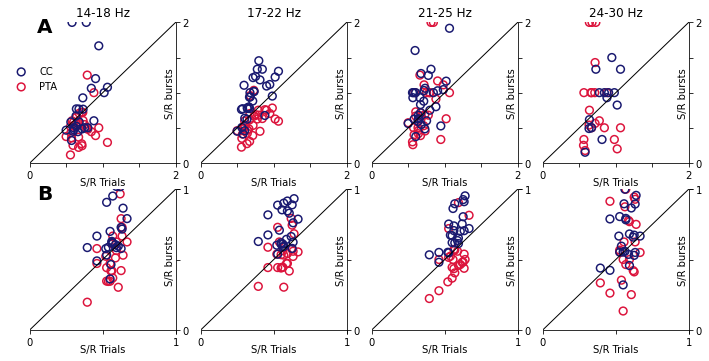

In [20]:
restrict = [[14,18],[17,22],[21,25],[24,30],]
plot3.plot_freq_check(lfp,lfp_bs,lfp_trials,lfp_ids,ecog,ecog_bs,ecog_trials,ecog_ids,restrict)

You can run the same types of tests as above on the subdivided data. It appears that the PT effect is happening in what is clearly the beta range, in the LFP **A** it is also happening in the lower ranges as well, but it is not specific to the lower range.

In [25]:
low = 17
high = 25
lfpf = lfp[(lfp['freq']>low) & (lfp['freq']<high) ]
ecogf = ecog[(ecog['freq']>low) & (ecog['freq']<high)]
pt_lfp_b, pt_lfp_c      = plot3.behav(lfpf,lfp_bs,lfp_trials,'pta', lfp_ids)
cc_lfp_b, cc_lfp_c      = plot3.behav(lfpf,lfp_bs,lfp_trials,'cc', lfp_ids)
pt_ecog_b, pt_ecog_c    = plot3.behav(ecogf,ecog_bs,ecog_trials,'pta',ecog_ids)
cc_ecog_b, cc_ecog_c    = plot3.behav(ecogf,ecog_bs,ecog_trials,'cc',ecog_ids)
behav_lfp = pd.concat([pt_lfp_b,cc_lfp_b])
behav_lfp['monkey'] = behav_lfp['loc'].astype(str).str[0]
behav_ecog = pd.concat([pt_ecog_b,cc_ecog_b])
behav_marco = behav_lfp[(behav_lfp.monkey=='M')]# & (behav_lfp.which=='cc')]
behav_pablo = behav_lfp[(behav_lfp.monkey=='P')]# & (behav_lfp.which=='cc')]
#%%
plot3.perm_binom_test(behav_marco,'marco','pta')
plot3.perm_binom_test(behav_marco,'marco','cc')
plot3.perm_binom_test(behav_pablo,'pablo','pta')
plot3.perm_binom_test(behav_pablo,'pablo','cc')
plot3.perm_binom_test(behav_ecog,'ecog','pta')
plot3.perm_binom_test(behav_ecog,'ecog','cc')

-------------------------------------------
Analysis of marco pta
Permutation:
5 of 10000 more extreme than observed p=  0.0005
Binomial:
13 out of 15 less than trial ratio
p=  0.003692626953124999
-------------------------------------------

-------------------------------------------
Analysis of marco cc
Permutation:
1 of 10000 more extreme than observed p=  0.0001
Binomial:
13 out of 15 greater than trial ratio
p=  0.003692626953124999
-------------------------------------------

-------------------------------------------
Analysis of pablo pta
Permutation:
12 of 10000 more extreme than observed p=  0.0012
Binomial:
15 out of 17 less than trial ratio
p=  0.0011749267578125
-------------------------------------------

-------------------------------------------
Analysis of pablo cc
Permutation:
17 of 10000 more extreme than observed p=  0.0017
Binomial:
13 out of 17 greater than trial ratio
p=  0.024520874023437493
-------------------------------------------

------------------------

# Discussion

So we have these two different methods. One focuses purely on the amplitude of the signal to detect burst. The other focuses on the consistency of the signal over time to do the same. We show that these two different methods pick out different parts of the signal and are defined by different characteristics in terms of frequency, duration, but most consistently and prominently in amplitude. Furthermore, the qualitative difference as seen in the averaged burst potentials is that the CC method picks up bursts with more consistent oscillatory activity, multiple cycles in fact. It is worth it to note that both methods are capable of picking up two cycle bursts, as we used this as the lower bound. That the PT method was not as oscillatory must be because each of the bursts would have violated a consistency threshold - which is why they were not calssified as CC bursts. One might be inclined to believe that maybe the CC method was just too conservative and the PT bursts might be actual CC bursts; but then why are they localized to different parts of the behavioral paradigm?


Could we pick up the type of bursts PTA recovers with the CC method? 

Why do the more non-rhythmic bursts occur more often in the repetition phase of th explore-exploit task?

